In [1]:
from Vissim_env_class import environment
from Actor_critic_class import ACAgent
from MasterAC_Agent import MasterAC_Agent
from MasterDQN_Agent import MasterDQN_Agent
from SurtracAgent import SurtracAgent


# Network Specific Libraries
from Balance_Functions import balance_dictionary

import numpy as np 
import pylab as plt
import os
import csv
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext tensorboard

#%tensorboard --logdir logs/fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_name  = 'Single_Cross_Straight'
vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'
sim_length = 3601

agent_type = "Surtrac"
Session_ID = "Surtrac"

# all controller actions
# all controller actions
Single_Cross_Straight_dictionary =\
{'junctions' : {
    # Controller Number 0 
    0 : {'default_actions' : {     1 : [1, 0, 1, 0],
                                     0 : [0, 1, 0, 1]
        },
         
         'all_actions' : {     1 : [1, 0, 1, 0],
                                     0 : [0, 1, 0, 1]
        },
 
         'link' : [1, 3, 5, 7],
         'lane' : ['1-1', '3-1', '5-1', '7-1'],
         'agent_type' : agent_type,
         'controled_by_com' : True,
         'green_time' : 6,
         'redamber_time' : 0,
         'amber_time' : 3, 
         'red_time' : 0,
         'state_size' : [4],
         'state_type' : 'Surtrac',
         'reward_type' : 'Queues' }
        },
 'demand' : { 'default' : [400, 400, 400, 400],
             
             0 : [200,200,200,200],
             1 : [400,400,400,400],
             2 : [900,500,900,500],
             3 : [1000,500,1000,500],
             4 : [700,500,700,500],
             5 : [500,700,500,700],
             6 : [500,1000,500,1000],
             7 : [500,900,500,900],
             8 : [400,400,400,400],
             9 : [200,200,200,200]
            }
 
}

In [3]:
env = environment(model_name, vissim_working_directory, sim_length, Single_Cross_Straight_dictionary,\
            Random_Seed = 42, timesteps_per_second = 1, mode = 'test', delete_results = True, verbose = True)

Working Directory set to: C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Straight.inpx ...
Model File load process successful.
Simulation length set to 3601 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
Deploying Network Parser...
Successful Network Crawl: Identified SignalControllers, Links and Lanes, Inputs.

Setting Simulation mode to: test
Starting Deployments of Signal Control Units...
SCUs successfully dep

In [4]:
Agents = {}
Agents[0] = SurtracAgent(0)


Deploying Surtrac Agent


In [5]:
# Counter to change the demande during test
demand_counter = 0
env.change_demand(env.vehicle_demand[demand_counter])

#Initialisation of the metrics
Episode_Queues = {} # 
Cumulative_Episode_Delays = {} # Delay at each junction
Cumulative_Episode_stop_Delays = {} # Delay at each junction

Cumulative_Totale_network_delay = [0]
Cumulative_Totale_network_stop_delay = [0]

queues = env.get_queues()
for idx, junction_queues in queues.items():
        Episode_Queues[idx] = [junction_queues]

delays = env.get_delays()
for idx, junction_delay in delays.items():
    Cumulative_Episode_Delays[idx] = [junction_delay]

stop_delays = env.get_stop_delays()
for idx, junction_stop_delay in stop_delays.items():
    Cumulative_Episode_stop_Delays[idx] = [junction_stop_delay]



start_state = env.get_state()

actions = {}

# Initialisation
for idx, s in start_state.items():
        actions[idx] = Agents[idx].choose_action(s)



while not env.done :
    
    
    surtrac_actions = {}
    surtrac_actions[0] = actions[idx][0]
    green_time = actions[idx][1]
    SARSDs = env.step(surtrac_actions, green_time)

    queues = env.get_queues()
    for idx, junction_queues in queues.items():
        Episode_Queues[idx].append(junction_queues)

    delays = env.get_delays()
    for idx, junction_delay in delays.items():
        Cumulative_Episode_Delays[idx].append(Cumulative_Episode_Delays[idx][-1]+junction_delay)

    stop_delays = env.get_stop_delays()
    for idx, junction_stop_delay in stop_delays.items():
        Cumulative_Episode_stop_Delays[idx].append(Cumulative_Episode_stop_Delays[idx][-1]+junction_stop_delay)

    Cumulative_Totale_network_delay.append(Cumulative_Totale_network_delay[-1]+env.get_delay_timestep())
    Cumulative_Totale_network_stop_delay.append(Cumulative_Totale_network_stop_delay[-1]+env.get_stop_delay_timestep())

    
    if env.action_required:

        actions = dict()
        for idx , sarsd in SARSDs.items():
            s,a,r,ns,d = sarsd

            # in order to find the next action you need to evaluate the "next_state" because it is the current state of the simulator
            actions[idx] = Agents[idx].choose_action(ns)
        

    if env.global_counter% 360 == 0:
        demand_counter += 1
        env.change_demand(env.vehicle_demand[demand_counter])


# Stop the simulation without erasing the database
env.Stop_Simulation(delete_results = False)
env = None


{0: (1, 6)}
{0: (1, 6.0)}
{0: (0, 5.0)}
{0: (0, 4.0)}
{0: (0, 5.0)}
{0: (1, 8.0)}
{0: (0, 6)}
{0: (0, 1.0)}
{0: (0, 7.0)}
{0: (1, 7.0)}
{0: (0, 1.0)}
{0: (0, 2.0)}
{0: (1, 8.0)}
{0: (0, 1.0)}
{0: (0, 1.0)}
{0: (0, 4.0)}
{0: (1, 7.0)}
{0: (0, 3.0)}
{0: (0, 2.0)}
{0: (1, 8.0)}
{0: (0, 1.0)}
{0: (0, 1.0)}
{0: (1, 6)}
{0: (1, 11.0)}
{0: (0, 6)}
{0: (0, 8.0)}
{0: (1, 8.0)}
{0: (0, 2.0)}
{0: (0, 1.0)}
{0: (1, 7.0)}
{0: (0, 6)}
{0: (0, 6)}
{0: (0, 14.0)}
{0: (0, 4.0)}
{0: (0, 9.0)}
{0: (1, 10.0)}
{0: (0, 6.0)}
{0: (0, 2.0)}
{0: (0, 6.0)}
{0: (1, 8.0)}
{0: (0, 8.0)}
{0: (0, 5.0)}
{0: (1, 8.0)}
{0: (0, 5.0)}
{0: (1, 8.0)}
{0: (0, 15.0)}
{0: (0, 4.0)}
{0: (0, 11.0)}
{0: (1, 11.0)}
{0: (0, 1.0)}
{0: (0, 2.0)}
{0: (1, 9.0)}
{0: (0, 3.0)}
{0: (0, 2.0)}
{0: (0, 3.0)}
{0: (1, 9.0)}
{0: (0, 1.0)}
{0: (0, 4.0)}
{0: (0, 5.0)}
{0: (0, 16.0)}
{0: (1, 12.0)}
{0: (0, 6.0)}
{0: (0, 4.0)}
{0: (0, 8.0)}
{0: (1, 10.0)}
{0: (0, 1.0)}
{0: (0, 1.0)}
{0: (1, 11.0)}
{0: (0, 7.0)}
{0: (0, 3.0)}
{0: (0, 4.0)}
{0: (1, 

In [ ]:
actions

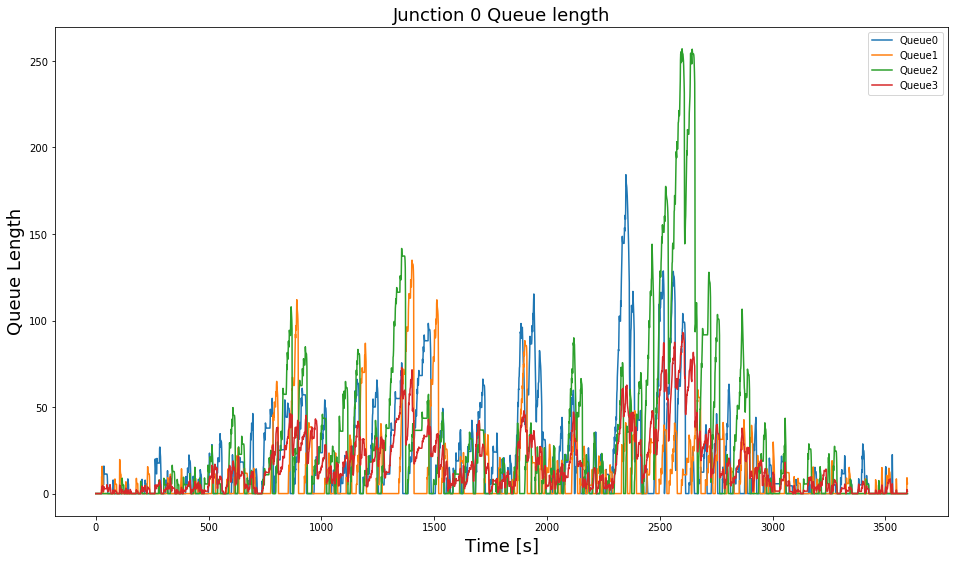

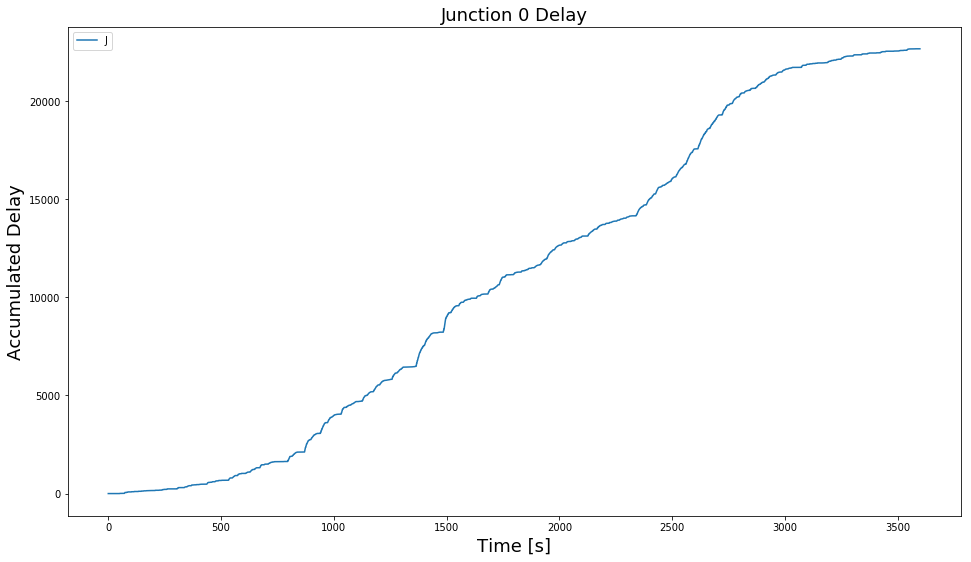

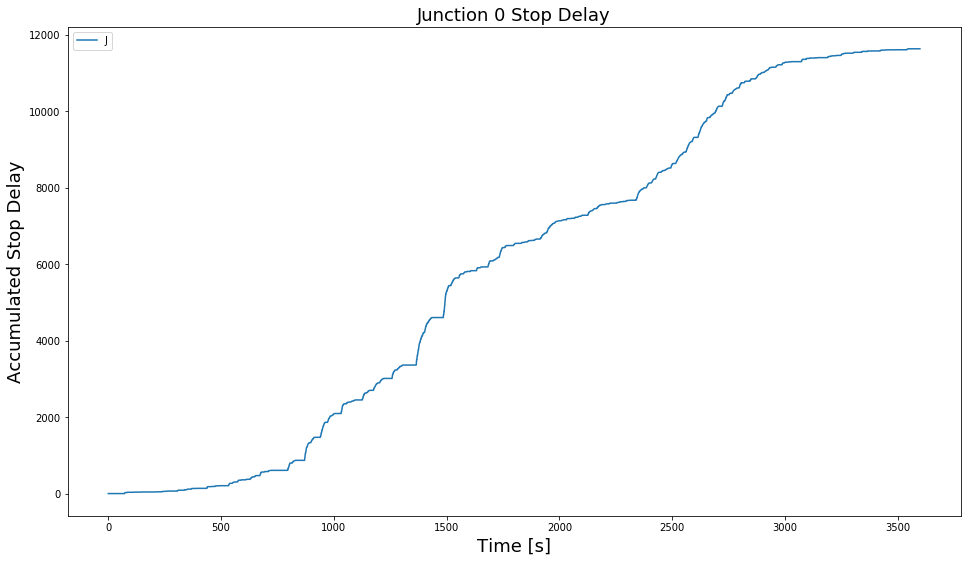

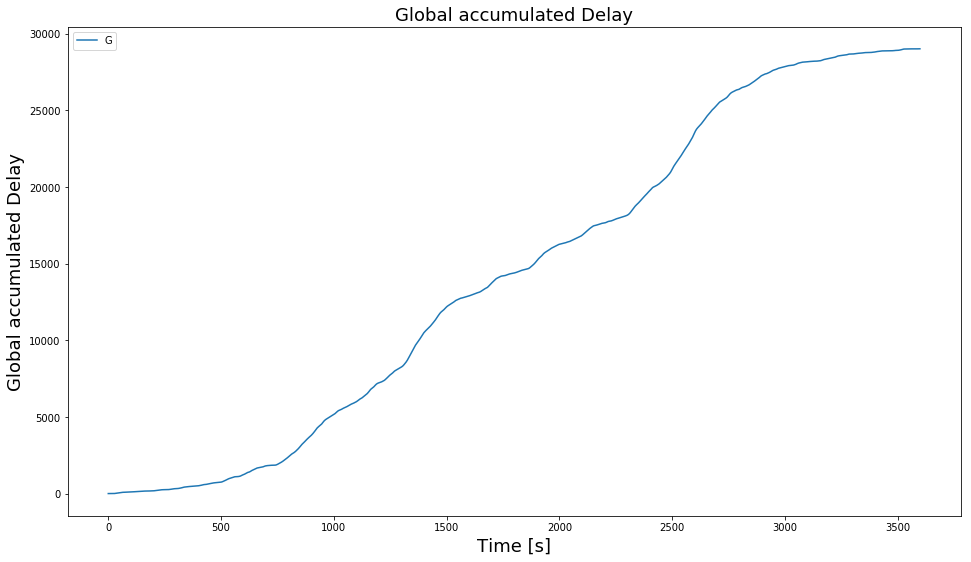

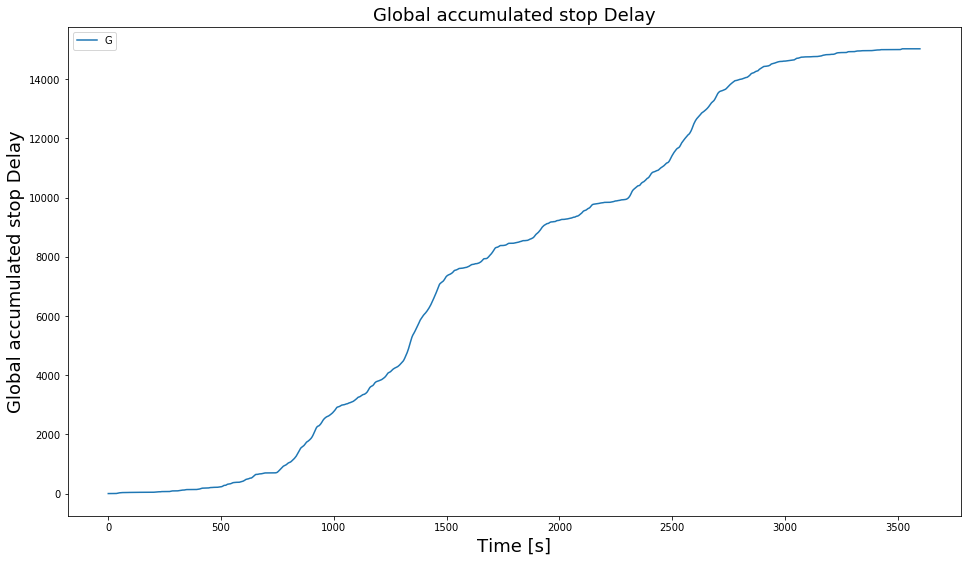

In [7]:
time = [t for t in range(len(Cumulative_Totale_network_stop_delay))]

# Queues ovzer time for each junction
for idx, queues in Episode_Queues.items():
    queues = np.array(Episode_Queues[0])
    queues = queues.T
    
    plt.figure('1'+str(idx),figsize=(16, 9))
    
    Queuesdf = pd.DataFrame()
    
    Queuesdf['Time'] = time
    Queues_legend = []
    
    for i, queue in enumerate(queues):
        plt.plot(queue)
        Queuesdf[str(i)] = queue
        Queues_legend.append("Queue"+str(i))
        
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Queue Length',fontsize=18)
    plt.title('Junction {} Queue length'.format(idx),fontsize=18)
    plt.gca().legend(Queues_legend)
    
    Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Junction{}_Queues.png".format(idx))               
    plt.savefig(Path)
    
    csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Junction{}_Queues.csv".format(idx))        
   
    Queuesdf.to_csv(csv_Path,index=False)
        
        
# Accumulated delay over time for each junction
for idx, delay in Cumulative_Episode_Delays.items():
    
    plt.figure('2'+str(idx),figsize=(16, 9))
    
    delaydf = pd.DataFrame()   
    delaydf['Time'] = time
    delaydf['Junction {} delay'.format(idx)] = delay
    
    plt.plot(delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Accumulated Delay',fontsize=18)
    plt.title('Junction {} Delay'.format(idx),fontsize=18)
    plt.gca().legend('Junction accumulated delay')
    
    Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                            "Junction{}_Cumulative_Delay.png".format(idx))
    csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Junction{}_Cumulative_Delay.csv".format(idx))   
    plt.savefig(Path)

    delaydf.to_csv(csv_Path,index=False)
    
    
# Accumulated stop delay over time for each junction
for idx, stop_delay in Cumulative_Episode_stop_Delays.items():
    
    plt.figure('3'+str(idx),figsize=(16, 9))
    
    stop_delaydf = pd.DataFrame()   
    stop_delaydf['Time'] = time
    stop_delaydf['Junction {} stop delay'.format(idx)] = stop_delay

    plt.plot(stop_delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Accumulated Stop Delay',fontsize=18)
    plt.title('Junction {} Stop Delay'.format(idx),fontsize=18)
    plt.gca().legend('Junction accumulated Stop delay')
    
    Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                            "Junction{}_Cumulative_stop_Delay.png".format(idx))
    csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Junction{}_Cumulative_stop_Delay.csv".format(idx))
    plt.savefig(Path)
    stop_delaydf.to_csv(csv_Path,index=False)
    
# Global Accumulated delay over time
plt.figure('4',figsize=(16,9))


Global_delaydf = pd.DataFrame()   
Global_delaydf['Time'] = time
Global_delaydf['Global accumulated Delay'] = Cumulative_Totale_network_delay

plt.plot(Cumulative_Totale_network_delay)
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('Global accumulated Delay',fontsize=18)
plt.title('Global accumulated Delay',fontsize=18)
plt.gca().legend('Global accumulated delay')

Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Total_Cumulative_Delay.png")
csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Total_Cumulative_Delay.csv")
plt.savefig(Path)
Global_delaydf.to_csv(csv_Path,index=False)

# Global Accumulated stop delay over time
plt.figure('5'+str(idx),figsize=(16, 9))

Global_stop_delaydf = pd.DataFrame()   
Global_stop_delaydf['Time'] = time
Global_stop_delaydf['Global accumulated stop Delay'] = Cumulative_Totale_network_stop_delay

plt.plot(Cumulative_Totale_network_stop_delay)
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('Global accumulated stop Delay',fontsize=18)
plt.title('Global accumulated stop Delay',fontsize=18)
plt.gca().legend('Global accumulated stop Delay')

Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Total_Cumulative_stop_Delay.png")
csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", Session_ID,\
                        "Total_Cumulative_stop_Delay.csv")
plt.savefig(Path)
Global_stop_delaydf.to_csv(csv_Path,index=False)




In [10]:
actions

{0: 1}

In [ ]:
model_name  = 'Single_Cross_Straight'
vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'
sim_length = 3601

agent_type = "Surtrac"
Session_ID = "Single_Cross_Straigth_Surtrac"

# all controller actions
Single_Cross_Straight_dictionary =\
{'junctions' : {
    # Controller Number 0 
    0 : {'default_actions' : {     0 : [1, 0, 1, 0],
                                     1 : [0, 1, 0, 1]
        },
         
         'all_actions' : {     0 : [1, 0, 1, 0],
                                     1 : [0, 1, 0, 1]
        },
 
         'link' : [1, 3, 5, 7],
         'lane' : ['1-1', '3-1', '5-1', '7-1'],
         'agent_type' : agent_type,
         'controled_by_com' : True,
         'green_time' : 6,
         'redamber_time' : 0,
         'amber_time' : 3, 
         'red_time' : 0,
         'state_size' : [5],
         'state_type' : 'QueuesSig' ,
         'reward_type' : 'Queues' }
        },
 'demand' : { 'default' : [400, 400, 400, 400]}
}




In [ ]:
env = environment(model_name, vissim_working_directory, sim_length,Single_Cross_Triple_dictionary8,\
            timesteps_per_second = 1, mode = 'test', delete_results = True, verbose = True)